In [3]:
from fmi.fmi.explore import *
from fmi.fmi.preprocessing import *
from fmi.fmi.pipeline import *
from fmi.fmi.retinanet import *

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

In [7]:
path = Path('/media/veracrypt2/Data Science/SIIM-Imgs/png')

df = pd.read_pickle('src/train_ready.pkl')

In [8]:
## Remove extension
df['id'] = df['id'].apply(lambda x: x[:-4])

In [9]:
df = df.sample(n = 1500).reset_index(drop = True)

In [10]:
print(df.shape)
df.head(2)

(1500, 11)


,id,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,boxes_list,labels_list,label,resized_boxes,scalar
0,a414f67f5735,f4be1e2350a2,0,1,0,0,"[[631.36341, 1054.02802, 971.69192, 1629.3452699999998], [1825.21422, 1332.23308, 2057.50193, 1656.35547]]","[Typical, Typical]",Typical,"[[216.154, 360.857, 332.669, 557.823], [624.881, 456.104, 704.407, 567.071]]",0.34236
1,575135cef005,79e2eafdb5cd,1,0,0,0,"[[0.0, 0.0, 1.0, 1.0]]",[Negative],Negative,"[[0.0, 0.0, 1.0, 1.0]]",NaN


In [11]:
def get_bbox(fn):
    boxes = df.loc[df['id'] == fn.stem, 'resized_boxes'].values[0]
    return boxes
    
def get_bbox_label(fn):
    labels = df.loc[df['id'] == fn.stem, 'labels_list'].values[0]
    return labels

In [12]:
items = get_image_files(path/'train')
items = L([fn for fn in items if fn.stem in df.id.tolist()])

In [13]:
def get_items(noop):
    return items

In [44]:
rats = []
for i in range(len(items)):
    im = Image.open(items[i])
    rats.append(im.size[0] / im.size[1])
    
np.array(rats).mean()

1.1616108155713802

<AxesSubplot:ylabel='Count'>

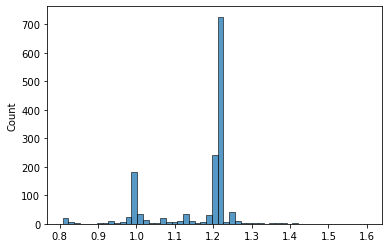

In [59]:
import seaborn as sns

sns.histplot(rats)

In [27]:
print(len(items))

1500


In [45]:
size = 256

db = DataBlock(
    blocks = (ImageBlock(), BBoxBlock, BBoxLblBlock),
    get_items = get_items,
    splitter = RandomSplitter(),
    get_y = [get_bbox, get_bbox_label],
    item_tfms = Resize((size,int(size * 1.16)), method = ResizeMethod.Squish),
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
    n_inp = 1
)

In [46]:
dls = db.dataloaders(path, bs = 16, num_workers = 0)

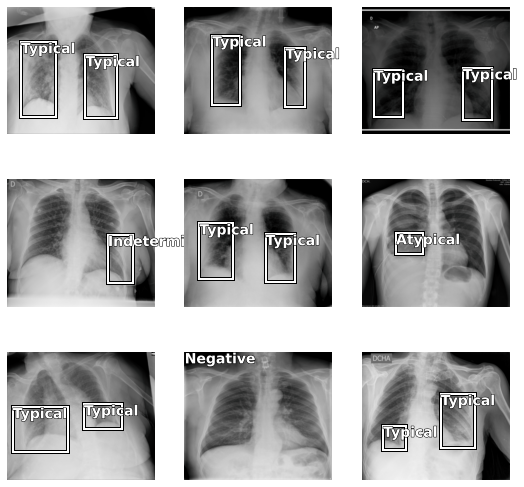

In [47]:
dls.show_batch()

---

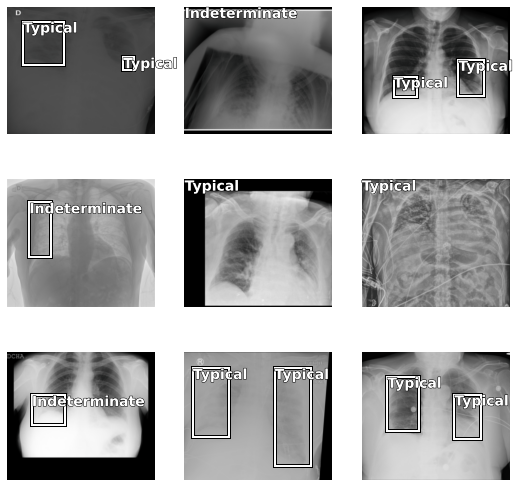

In [48]:
b = dls.one_batch()
dls.show_batch(b)

In [49]:
xb, y1b, y2b = b
print(f'Type of: xb: {type(xb)},\n y1b: {type(y1b)},\n y2b: {type(y2b)}')
print(f'Shape of: xb: {xb.shape},\n y1b: {y1b.shape},\n y2b: {y2b.shape}')

Type of: xb: <class 'fastai.torch_core.TensorImage'>,
 y1b: <class 'fastai.vision.core.TensorBBox'>,
 y2b: <class 'fastai.torch_core.TensorMultiCategory'>
Shape of: xb: torch.Size([16, 3, 256, 296]),
 y1b: torch.Size([16, 2, 4]),
 y2b: torch.Size([16, 2])


In [50]:
print(dls.vocab)

['#na#', 'Atypical', 'Indeterminate', 'Negative', 'Typical']


Shapes: (batch size of 6)
* xb:
    6 images, 3 channels, 128 width/height 
* y1b: (Bounding Box)
    6 images, at most 2 boxes per image for this batch, 4 coordinates for box
* y2b: (BB label)
    6 images, label for (at most) 2 boxes

In [51]:
print(xb[0,0,:5,:5])
print(y1b[0])
print(y2b[0])
print(dls.vocab[y2b[0,0]], dls.vocab[y2b[0,1]])

TensorImage([[-1.1247, -1.1075, -1.1075, -1.1589, -1.2445],
        [-1.1589, -1.1418, -1.0904, -1.0562, -1.1075],
        [-1.1760, -1.1589, -1.1418, -1.0733, -1.0562],
        [-1.1760, -1.1418, -1.1247, -1.0904, -1.0562],
        [-1.1589, -1.1247, -1.0904, -1.0733, -1.0562]], device='cuda:0')
TensorBBox([[-0.7887, -0.7708, -0.2277, -0.0985],
        [ 0.5673, -0.2143,  0.7157, -0.0053]], device='cuda:0')
TensorMultiCategory([4, 4], device='cuda:0')
Typical Typical


---

In [52]:
aspect_ratios = [0.5, 1, 2]
scales = [2**0, 2**(-1/3), 2**(-2/3)]

n_anchors = len(aspect_ratios) * len(scales)

In [53]:
encoder = create_body(models.resnet34, pretrained = True)
arch = RetinaNet(encoder, n_classes = len(dls.vocab), final_bias = -4, n_anchors = n_anchors)
crit = RetinaNetFocalLoss(scales=scales, ratios=aspect_ratios)

In [54]:
def _retinanet_split(m): 
    return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [55]:
learn = Learner(
    dls, 
    arch, 
    loss_func=crit, 
    splitter=_retinanet_split
)

In [56]:
learn.freeze()

SuggestedLRs(valley=tensor(0.0002))

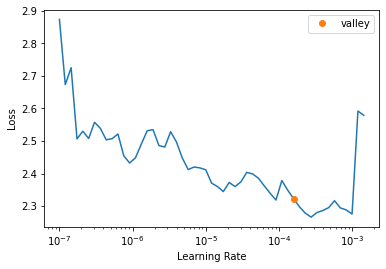

In [57]:
learn.lr_find()

In [58]:
learn.fit_one_cycle(3, lr_max = 2e-4)

epoch,train_loss,valid_loss,time
0,1.726266,1.480055,01:10
1,1.415143,1.354710,01:00
2,1.220511,1.360975,01:00


In [60]:
learn.unfreeze()

SuggestedLRs(valley=tensor(6.3096e-07))

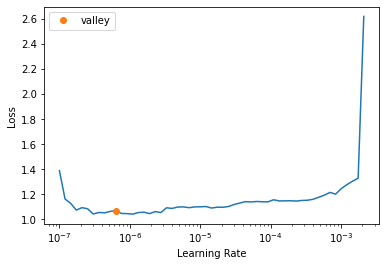

In [61]:
learn.lr_find()

In [62]:
learn.fit_one_cycle(5, lr_max = slice(2e-7, 1e-5))

epoch,train_loss,valid_loss,time
0,1.131746,1.402783,01:03
1,1.132340,1.372141,01:03
2,1.097808,1.402139,01:03
3,1.055148,1.371829,01:04
4,1.036969,1.388840,01:03


In [73]:
#learn.save('tmp')

In [74]:
learn.export('micro_learner_rn34_7e_squish.pkl')

In [75]:
learn.load('tmp')
learn.to('cuda');

---

# Look at results:

In [75]:
####&&#### xb, y1b, y2b = b
print(f'Shape of input ImageTensor: {xb.shape}\nBatch size: {xb.shape[0]}, {xb.shape[1]} channels, {xb.shape[2]}x{xb.shape[3]} Image')
print(f'Shapes of y: {y1b.shape, y2b.shape}\nBatch size: {y1b.shape[0]},(in this batch there are at most) no. of BBoxes per Image: {y1b.shape[1]}')

Shape of input ImageTensor: torch.Size([16, 3, 256, 296])
Batch size: 16, 3 channels, 256x296 Image
Shapes of y: (torch.Size([16, 2, 4]), torch.Size([16, 2]))
Batch size: 16,(in this batch there are at most) no. of BBoxes per Image: 2


In [76]:
####&&####
y1_pred, y2_pred, sizes = preds = learn.model.eval()(xb)

In [77]:
print(f'Shapes of prediction: {y1_pred.shape, y2_pred.shape},\nSizes: {sizes}')

Shapes of prediction: (torch.Size([16, 54234, 5]), torch.Size([16, 54234, 4])),
Sizes: [[32, 37], [64, 74], [8, 10], [4, 5], [2, 3]]


In [78]:
print(f'There are {len(sizes)} different (square) grids of the sizes: {", ".join([str(s[0]) + "x" + str(s[1]) for s in sizes])}.')
print(f'For each grid cell (4 in the 2x2 case), there are 9 anchors, resulting in {y1_pred.shape[1]} BBox predictions')

There are 5 different (square) grids of the sizes: 32x37, 64x74, 8x10, 4x5, 2x3.
For each grid cell (4 in the 2x2 case), there are 9 anchors, resulting in 54234 BBox predictions


$$ (32^2 + 64^2 + 8^2 + 4^2 + 2^2) \cdot 9 = 46.836 $$

In [79]:
ratios = aspect_ratios

In [80]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
##&
from matplotlib import patches 
import matplotlib.patheffects as path_effects ##&
from cycler import cycler

def _draw_outline(o, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([path_effects.Stroke(
        linewidth=lw, foreground='black'), path_effects.Normal()])

#def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
def draw_rect(ax:plt.Axes, b, color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)
        
unpad = crit._unpad

def nms(boxes, scores, thresh=0.3):
    idx_sort = scores.argsort(descending=True)  ## sort the indices of scores such that the index of the element with the highest value is in front
    boxes, scores = boxes[idx_sort], scores[idx_sort]  ## sort the boxes and scores in above fashion
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

def my_process_output(clas_pred, bbox_pred, sizes, detect_thresh = 0.25):
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[] 
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

def my_show_preds(img, clas_pred, bbox_pred, sizes, detect_thresh = 0.25, classes = None, ax = None):
    bbox_pred, scores, preds = my_process_output(clas_pred, bbox_pred, sizes, detect_thresh)
    ##& not moved to the cpu as before
    #set_trace()
    if len(scores) != 0: ##& added condition
        to_keep = nms(bbox_pred, scores) ## added
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu() ##& moved to cpu here
        t_sz = torch.Tensor([*img.size])[None].float() #& assume input to be ImageTensor
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax) ##& in the loop before
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[] ##& changed to earlier def.
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    ##& not moved to the cpu as before
    if len(scores) != 0: ##& added condition
        to_keep = nms(bbox_pred, scores) ## added
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu() ##& moved to cpu here
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax=ax) ##& in the loop before
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        #draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')
        draw_rect(ax, [bbox[0],bbox[1],bbox[2],bbox[3]], text=f'{txt} {scr:.2f}')
        
        
def show_bbox_img(img, bbox, ax = None):
    if not ax: fig, ax = plt.subplots()
    img.show(ctx = ax)
    bbox.show(ctx = ax)
    
    return ax;
        
def show_results(learn, start=0, n=5, detect_thresh=0.35, figsize=(10,25)):
    #x,y = learn.data.one_batch(DatasetType.Valid, cpu=False)
    x, *y = learn.dls.valid.one_batch()
    with torch.no_grad():
        z = learn.model.eval()(x)
    _,axs = plt.subplots(n, 2, figsize=figsize)
    for i in range(n):
        #img, bbox = learn.data.valid_ds[start+i]
        #img.show(ax=axs[i,0], y=bbox)
        #show_preds(img, z, start+i, detect_thresh=detect_thresh, classes=learn.data.classes, ax=axs[i,1])
        img, *bbox = learn.dls.valid.dataset[start + i]
        lbl_bbox = LabeledBBox(bbox[0], dls.vocab[bbox[1]])
        show_bbox_img(img,lbl_bbox, axs[i,0])
        show_preds(img, z, start+i, detect_thresh=detect_thresh, classes=dls.vocab, ax=axs[i,1])

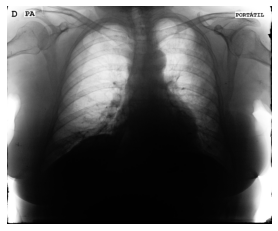

In [81]:
idx = 4
img = dls.valid_ds[idx][0]
show_preds(img, preds, idx, detect_thresh = 0.4, classes = dls.vocab)

----

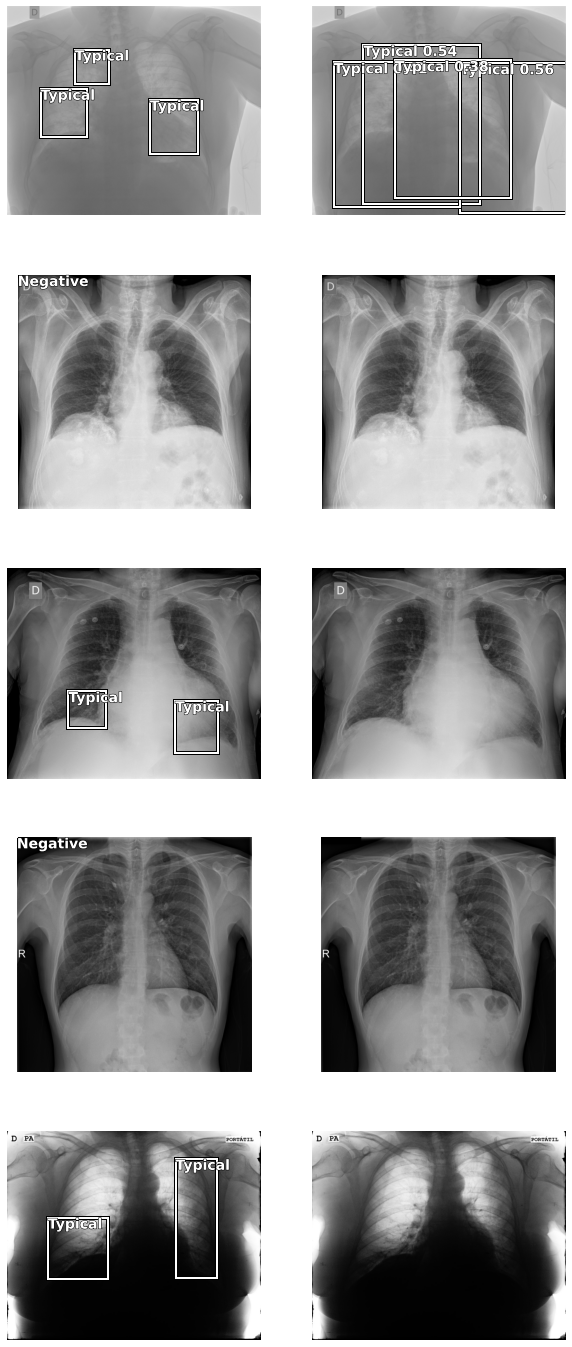

In [82]:
show_results(learn)

---
# mAP

In [83]:
def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.35, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    with torch.no_grad():
        ##& for input,target in progress_bar(dl):
        for input, *target in progress_bar(dl):
            target[0], target[1] = target[0].as_subclass(Tensor), target[1].as_subclass(Tensor) ##& for torch.min/max in interception()
            output = model(input)
            for i in range(target[0].size(0)): ##& target[0].size(0) = batch_size
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh)
                if torch.nonzero(target[0][i]).numel()==0: ##&
                    continue
                tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
                if len(bbox_pred) != 0 and len(tgt_bbox) != 0:
                    ious = IoU_values(bbox_pred, tgt_bbox)
                    max_iou, matches = ious.max(1)
                    detected = []
                    for i in range_of(preds):
                        if max_iou[i] >= iou_thresh and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                            detected.append(matches[i])
                            tps.append(1)
                        else: tps.append(0)
                    clas.append(preds.cpu())
                    p_scores.append(scores.cpu())
                n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores,0), torch.cat(clas,0)
    fps = 1-tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    #return tps, clas
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls.numel() != 0 and tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + 1e-8)
            recall = tps_cls / (n_gts[cls] + 1e-8)
            aps.append(compute_ap(precision, recall))
        else: aps.append(0.)
    return aps

In [84]:
L = compute_class_AP(learn.model, dls.valid, len(dls.vocab)-1)

In [85]:
for ap,cl in zip(L, dls.vocab[1:]): print(f'{cl}: {ap:.6f}')

Atypical: 0.000000
Indeterminate: 0.000000
Negative: 0.000000
Typical: 0.030169
